## Preprocessing

In [3]:
# load medQuad preprocessed dataset
import json

# Open the JSON file
with open("train.json", 'r') as f:
    # Load the contents of the file into a variable
    json_data = f.read()

# Parse the JSON data into a Python dictionary
dataset_raw = json.loads(json_data)

In [4]:
print(type(dataset_raw))

<class 'dict'>


### Finding the cutoff pnt!

4299
226.57687886190544
152.0
2821


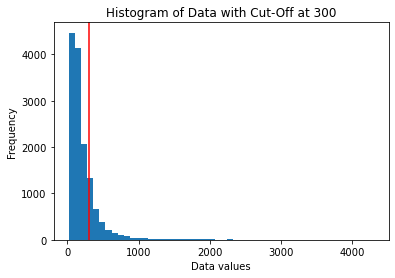

cnt 13918


In [5]:
import numpy as np
dataset = []
maxi = []
c = 0
for k in dataset_raw:
  title = "Title: " + str(k.split("|")[0])+"\n"
  syns = "Synonyms: " + ", ".join(dataset_raw[k]["synonyms"]) + "\n"
  groups = "Groups: " + str(dataset_raw[k]["group"]) + "\n\n"

  for qa in range(len(dataset_raw[k]["QAs"])):
    c += 1
    typee = "Type: " + str(dataset_raw[k]["QAs"][qa]["type"]) + "\n\n"
    question = "Question: " + str(dataset_raw[k]["QAs"][qa]["question"]) + "\n\n"
    answer = "Answer: " + str(dataset_raw[k]["QAs"][qa]["answer"]) + "\n"
    
    final = title + syns + groups + typee + question + answer
    maxi.append(len(final.split()))
      
    
print(max(maxi))
print(np.mean(maxi))
print(np.median(maxi))
above_230 = [x for x in maxi if x > 300]

# Use the len() function to count how many numbers are in the new list
count = len(above_230)
print(count)

import matplotlib.pyplot as plt
import numpy as np
plt.hist(maxi, bins=50)

# Add a vertical line to show the cut-off number
cutoff = 300
plt.axvline(x=cutoff, color='red')

# Add labels and a title
plt.xlabel('Data values')
plt.ylabel('Frequency')
plt.title(f'Histogram of Data with Cut-Off at {cutoff}')

# Display the plot
plt.show()

print("cnt",c)

In [ ]:
import numpy as np
dataset = []
CUTOFF = 500
for k in dataset_raw:
  title = "Title: " + str(k.split("|")[0])+"\n "
  syns = "Synonyms: " + ", ".join(dataset_raw[k]["synonyms"]) + "\n "
  groups = "Groups: " + str(dataset_raw[k]["group"]) + "\n\n "

  for qa in range(len(dataset_raw[k]["QAs"])):
    c += 1
    typee = "Type: " + str(dataset_raw[k]["QAs"][qa]["type"]) + "\n "
    question = "Question: " + str(dataset_raw[k]["QAs"][qa]["question"]) + "\n\n "
    answer = "Answer: " + str(dataset_raw[k]["QAs"][qa]["answer"])
    
    final = title + syns + groups + typee + question + answer

    dataset.append(final)

In [ ]:
dataset[5]

"Title: Breast Cancer\n Synonyms: \n Groups: Disorders\n\n Type: treatment\n Question: What are the treatments for Breast Cancer ?\n\n Answer: There are a number of treatments for breast cancer, but the ones women choose most often -- alone or in combination -- are surgery, hormone therapy, radiation therapy, and chemotherapy. What Standard Treatments Do Here is what the standard cancer treatments are designed to do. - Surgery takes out the cancer and some surrounding tissue.   - Hormone therapy keeps cancer cells from getting most of the hormones they need to survive and grow.  - Radiation therapy uses high-energy beams to kill cancer cells and shrink tumors and some surrounding tissue.  -  Chemotherapy uses anti-cancer drugs to kill most cancer cells. Surgery takes out the cancer and some surrounding tissue. Hormone therapy keeps cancer cells from getting most of the hormones they need to survive and grow. Radiation therapy uses high-energy beams to kill cancer cells and shrink tumor

In [1]:
import pickle

# Saving
with open('bloom_train.pkl', 'wb') as f:
    # Dump the list using pickle
    pickle.dump(dataset, f)


NameError: name 'dataset' is not defined

## Opening processed shiz

In [2]:
import pickle

# Loading
with open('bloom_train.pkl', 'rb') as f:
    # Load the list using pickle
    dataset = pickle.load(f)

# Print the loaded list
print(len(dataset))

13918


## Bloom Preprocessing

In [3]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [4]:
from datasets import Dataset, DatasetDict

train_dict ={ 
    "text": train_dataset,
}
train_dataset = Dataset.from_dict(train_dict)


test_dict ={ 
    "text": test_dataset,
}
test_dataset = Dataset.from_dict(test_dict)


dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Training

## Importing Bloom model to train

In [4]:
from transformers import BloomTokenizerFast, BloomForCausalLM
from datasets import load_dataset
from transformers import Trainer, TrainingArguments

model_id="bigscience/bloom-560m"

tokenizer = BloomTokenizerFast.from_pretrained(model_id,)
model = BloomForCausalLM.from_pretrained(model_id)

2023-05-14 17:24:09.560851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 17:24:09.721324: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-14 17:24:09.756699: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-14 17:24:10.439945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [5]:
# CUTOFF = 500
CUTOFF = 300

## Preprocessing (Tokenization)

In [6]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=CUTOFF)

In [7]:
tokenized_dataset = dataset.map(tokenize_function, batched=True, num_proc=8, remove_columns=["text"])

Map (num_proc=8):   0%|          | 0/11134 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2784 [00:00<?, ? examples/s]

In [8]:
assert len(tokenized_dataset["train"][0]["input_ids"]) == CUTOFF
assert len(tokenized_dataset["test"][0]["input_ids"]) == CUTOFF

In [9]:
print(len(tokenized_dataset["train"][1]["input_ids"]))
print(len(tokenized_dataset["test"][1]["attention_mask"]))

300
300


### Applying truncation

In [10]:
block_size = CUTOFF
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
	k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [11]:
lm_datasets = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=100,
    num_proc=8,
)

Map (num_proc=8):   0%|          | 0/11134 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2784 [00:00<?, ? examples/s]

In [12]:
print(len(lm_datasets["train"][2]["input_ids"]))
print(len(lm_datasets["train"][2]["attention_mask"]))
print(len(lm_datasets["test"][2]["labels"]))

300
300
300


### Actual Training

In [13]:
training_args = TrainingArguments(
    f"bloom3b-finetuned-medQuad",  # Path to save  (Auto creates this folder name)
    per_device_train_batch_size=2,
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    optim="adafactor",
    logging_steps=40,
    save_strategy='epoch',
    weight_decay=0.1,
    learning_rate=5e-6,
    evaluation_strategy='steps',
    eval_steps=400,
    tf32=False,
    per_device_eval_batch_size=2,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
)

trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
400,1.192800,1.151663
800,1.102200,1.071955
1200,1.014200,1.021714
1600,0.942100,0.988326
2000,0.888300,0.964295
2400,0.841700,0.939108
2800,0.796700,0.923502
3200,0.792400,0.914157
3600,0.813100,0.903415
4000,0.808900,0.896043


RuntimeError: File bloom3b-finetuned-medQuad/checkpoint-4173/training_args.bin cannot be opened.

In [19]:
import torch
torch.cuda.empty_cache()

# Testing/Inference

### Importing the pretrained Model

In [2]:
from transformers import BloomTokenizerFast, BloomForCausalLM
from datasets import load_dataset
from transformers import Trainer, TrainingArguments

model_id="bigscience/bloom-560m"

tokenizer = BloomTokenizerFast.from_pretrained(model_id)  # Can give checkpoint path, or model id cause tokenizer is not trained lol
model = BloomForCausalLM.from_pretrained("bloom3b-finetuned-medQuad/checkpoint-2783")  # Checkpoint path
model.eval()

2023-05-25 14:39:08.963942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 14:39:09.107784: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 14:39:09.144805: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-25 14:39:09.756067: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0): BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (1): BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementw

### Get the current cuda number

In [3]:
import torch 
torch.cuda.current_device()

0

### Create a generator using pipeline

In [4]:
from transformers import pipeline
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = pipeline('text-generation', model=model.to(device),device = 0, tokenizer=tokenizer,do_sample=False)

In [10]:
print("Running on", device)

device(type='cuda')

### Unprocessed inference

In [9]:
with torch.no_grad():
    print(generator(preprocess("I have stomach problem. What is wrong?"), max_length=300))

[{'generated_text': '\n Question: I have stomach problem. What is wrong?\n\n Answer:  The stomach is a hollow, muscular organ that is located just below the stomach tube, just below the esophagus, and just below the stomach. The stomach is made up of two parts: a large, muscular stomach tube and a small, muscular stomach pouch. The stomach tube is made up of muscles and a tube called the esophagus. The pouch is made up of fat and lined with mucus. The stomach tube and pouch are connected by a tube called the esophagus. The esophagus carries food from the stomach to the small intestine. The esophagus and stomach tube are connected by a tube called the stomach. The stomach is the main stomach, which is where most of the food gets digested. The stomach is made up of two parts: a large, muscular stomach tube and a small, muscular stomach pouch. The stomach tube is made up of muscles and a tube called the esophagus. The pouch is made up of fat and lined with mucus. The stomach tube and pouc

### Preprocessing the output stuff

In [18]:
import re
from tqdm.notebook import tqdm
CUTOFF = 300
def preprocess(text):
    #We add 'Question :' and 'Answer #1:' at the start and end of the prompt
    return "\n Question: " + text + "\n\n Answer: "

def generate(text):
    preprocessed_text = preprocess(text)
    result = generator(preprocessed_text, max_length=CUTOFF)
    output = re.split(r'\n Question: |\n\n Answer:  ',result[0]['generated_text'])[2]
    return output

def preprocessList(texts):
    #We add 'Question :' and 'Answer #1:' at the start and end of the prompt
    for i in range(len(texts)):
        texts[i] = "\n Question: " + texts[i] + "\n\n Answer: "
    return texts

def generateList(texts):
    preprocessed_texts = preprocessList(texts)
    result = generator(preprocessed_texts, max_length=CUTOFF)
    print(result)
    return 1

def processResult(result):
    for i in tqdm(range(len(result))):
        result[i] = re.split(r'\n Question: |\n\n Answer:  ',result[i][0]['generated_text'])[2]
    return result

def generateDF(df):
    df = df.apply(preprocess)
    results = []
    for txt in tqdm(df.values.tolist()):
        with torch.no_grad():
            results.append(generator(txt, max_length=CUTOFF))
    output = processResult(results)
    return output

### Inferencing the test set

In [12]:
import pandas as pd
df = pd.read_csv("new_dataset.csv")  # sorry for the hagas naming convention xd

In [13]:
df.head()

,AnswerID,Answer,Extracted_Question,Extracted_Answer
0,ADAM_0003147_Sec1.txt,Question: What is (are) Polycystic ovary syndr...,What is (are) Polycystic ovary syndrome ? (Als...,Polycystic ovary syndrome is a condition in wh...
1,ADAM_0003147_Sec2.txt,Question: What causes Polycystic ovary syndrom...,What causes Polycystic ovary syndrome ? (Also ...,PCOS is linked to changes in hormone levels th...
2,ADAM_0002818_Sec2.txt,Question: What causes Noonan syndrome ?\nURL: ...,What causes Noonan syndrome ?,Noonan syndrome is linked to defects in severa...
3,ADAM_0002818_Sec7.txt,Question: What are the complications of Noonan...,What are the complications of Noonan syndrome ?,- Buildup of fluid in tissues of body (lymphed...
4,ADAM_0002818_Sec9.txt,Question: How to prevent Noonan syndrome ?\nUR...,How to prevent Noonan syndrome ?,Couples with a family history of Noonan syndro...


In [14]:
questions = df["Extracted_Question"]
answers = df["Extracted_Answer"]

In [15]:
answers.head()

0    Polycystic ovary syndrome is a condition in wh...
1    PCOS is linked to changes in hormone levels th...
2    Noonan syndrome is linked to defects in severa...
3    - Buildup of fluid in tissues of body (lymphed...
4    Couples with a family history of Noonan syndro...
Name: Extracted_Answer, dtype: object

In [20]:
len(answers)

2479

In [ ]:
#### Tip: the following one takes a while to run... I think this should be done in batches, instead of single single. I was too lazy
pred_answers = generateDF(questions)

  0%|          | 0/2479 [00:00<?, ?it/s]

### Calculating BLEU and ROUGE metrics

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import  word_tokenize
import numpy as np
from rouge import Rouge

# See this for input references - https://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.sentence_bleu
# A Caption should be a list of strings.
# Reference Captions are list of actual captions - list(list(str))
# Predicted Caption is the string caption based on your model's output - list(str)
# Make sure to process your captions before evaluating bleu scores -
# Converting to lower case, Removing tokens like <start>, <end>, padding etc.

def bleu1(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)


def bleu4(reference_captions, predicted_caption):
    return 100 * sentence_bleu(reference_captions, predicted_caption,
                               weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)

rouge = Rouge()

# pred_caption = word_tokenize(pred_caption.lower())

ground_truth = answers.values.tolist()
generated_ans = pred_answers

Bleu1 = []
Bleu4 = []
rouge_1_score = []
rouge_2_score = []
rouge_L_score = []

for i in range(len(ground_truth)):
    grndAns = ground_truth[i]
    gen_ans = generated_ans[i]
    
    # BLEU SCORES
    gen_ans_ = word_tokenize(gen_ans.lower())
    grndAns_ = word_tokenize(grndAns.lower())
    bleu1 = bleu1(grndAns_, gen_ans_)
    bleu4 = bleu4(grndAns_, gen_ans_)
    Bleu1.append(bleu1)
    Bleu4.append(bleu4)
    
    # Rouge
    scores = rouge.get_scores(gen_ans, grndAns)
    r1s = scores[0]['rouge-1']['f'] # f1 score
    r2s = scores[0]['rouge-2']['f']
    rLs = scores[0]['rouge-l']['f']
    rouge_1_score.append(r1s)
    rouge_2_score.append(r2s)
    rouge_L_score.append(rLs)
    

print("BLEU 1 Gram: ", np.mean(Bleu1))
print("BLEU 4 Gram: ", np.mean(Bleu4))
print("ROUGE 1 Gram:", np.mean(rouge_1_score))
print("ROUGE 2 Gram:", np.mean(rouge_2_score))
print("ROUGE L Gram:", np.mean(rouge_L_score))

### Single single inference

In [21]:
textii = ["I have headache. What is wrong with me?", "I haven't eaten anything since morning. I have stomach ache. Why?"]
print(generateList(textii))

[[{'generated_text': "\n Question: I have headache. What is wrong with me?\n\n Answer:  The headache may suggest an enlarged sinus or throat or possible cancerous tumor in the brain. Because it is part of normal aging, there may be no physical signs of pain. However, headache may be triggered by a substance in the stomach causing pain on the tongue, cheeks and chin as well as the throat. This can occur when having a stomach attack from a substance called aspirin, which is often given by mouth. The headache may seem to occur more often for some individuals and is associated with a high triglyceride (a type of fat) in the blood. The headache may also occur without stomach problems. The headache can occur when you're thinking about a headache or feeling the need to move about. Most individuals with headache in adolescence will have it for many years before it attacks them.\nHeadaches occur when you have inflammation in the brain's tissue (inflammation), such as due to a viral infection or

In [26]:
texti = "I have headache. What is wrong with me?"
print(generate(texti))

[{'generated_text': '\nQuestion: I have headache. What is wrong with me?\n\n Answer:  Headache is a common symptom of migraine. Migraine is a group of headache disorders that affect the brain and the nerves that control movement. Migraine headaches are caused by a blockage in the blood flow to the brain. Blockage occurs when the blood flow to the brain is blocked by a substance called a migraine headache drug. Migraine headaches are most common in the head and neck area, but they can affect other parts of the body. Migraine headaches are often associated with a migraine, which is a condition in which the head and neck are affected. Migraine headaches are often triggered by a substance called a migraine headache drug. Migraine headaches are most common in the head and neck area, but they can affect other parts of the body. Migraine headaches are often triggered by a substance called a migraine headache drug. Migraine headaches are most common in the head and neck area, but they can affe

In [24]:
texti = "I haven't eaten anything since morning. I have stomach ache. Why?"
print(generate(texti))

The stomach is a hollow organ that is found in the lower part of the stomach. The stomach is part of the digestive system, which is a series of organs that digest food and absorb nutrients. The digestive system is made up of the mouth, esophagus, stomach, and small intestine. The digestive system is responsible for breaking down food into smaller pieces that are passed from the mouth to the small intestine for digestion. The digestive system is also responsible for absorbing nutrients from food and sending them to the body's tissues for use. The digestive system is also responsible for removing waste products from food and removing toxins from the body. The digestive system is also responsible for absorbing nutrients from food and sending them to the body's tissues for use. The digestive system is also responsible for removing waste products from food and removing toxins from the body. The digestive system is also responsible for absorbing nutrients from food and sending them to the bo

In [53]:
texti = "I haven't eaten anything since morning. I have stomach ache. Why?"
print(generate(texti))

A lack of dietary fiber can cause stomach pain. If the person has low food intake, digesting fibers may become more difficult, even when the fibers are needed. The problem can be acute (during an attack), and can cause the person to suffer more from pain as the stomach pain gets worse. Sometimes the fiber will stick to the wall of the stomach instead of passing through the wall, leaving a hole in the stomach wall. These are called rebound contractions. Rebound contractions are a risk factor for abdominal pain, and many people have rebound contractions after eating a fasted meal.  The main type of food fiber people are at risk for is casein, which is found in milk, cheese, and soy milk. It also contains digestive enzymes. This type of fiber is called caseose, which is present in dairy products, especially cheeses. These enzymes break down caseose, reducing the amount of fiber found in casein. The digestive enzymes, when the body absorbs them, produce the problems most often seen in peop

In [55]:
texti = "What causes Noonan syndrome?"
print(generate(texti))

/home/jjhaveri/.local/lib/python3.9/site-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


The cause of Noonan syndrome is not completely understood. Some theories relate Noonan syndrome to changes in the environment (e.g. changes in temperature), nutritional factors (e.g. malnutrition), or an abnormality of one of the X chromosomes. It is likely that both factors contribute to the features of Noonan syndrome. Most research efforts have involved identifying genetic abnormalities in these parents, testing more than one family, and evaluating multiple families. The results of this research have been mixed. It is suggested that people with Noonan syndrome may differ in their genetic makeup, and that the genetic predisposition to the various facets of this disorder is multiple.  It is also thought that some people may not develop Noonan syndrome, although it is unclear whether a particular risk factor is responsible.  Other disorders are linked to noonan syndrome, and have been studied in order to establish whether one of these syndromes can also be caused by genetic mutations. 

### Inferencing untrained model's performance

In [56]:
from transformers import BloomTokenizerFast, BloomForCausalLM
from datasets import load_dataset
from transformers import Trainer, TrainingArguments

model_id="bigscience/bloom-560m"

tokenizer = BloomTokenizerFast.from_pretrained(model_id)
model2 = BloomForCausalLM.from_pretrained(model_id)
model2.eval()

In [77]:
from transformers import pipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator2 = pipeline('text-generation', model=model2.to(device),device = 0, tokenizer=tokenizer,do_sample=False)

In [64]:
import re
CUTOFF = 300
def preprocess(text):
    #We add 'Question :' and 'Answer #1:' at the start and end of the prompt
    return "\n Question: " + text + "\n\n Answer: "

def generate2(text):
    preprocessed_text = preprocess(text)
    result = generator2(preprocessed_text, max_length=CUTOFF)
    output = re.split(r'\n Question: |\n\n Answer:  ',result[0]['generated_text'])[2]
    return output

In [66]:
texti = "What causes Noonan syndrome?"
print(generate2(texti))

This disease is caused by the defective action of the normal testifying cells, and this is due to mutation of the gene that encodes the protein PR10. PR10 is the protein used by the testifying and follicular cells to transmit signals from the test to the follicular cells. It is present as a soluble protein on the blood plasma. PR10 is known to be absent in the skin of some patients with Turner syndrome. So this abnormality in the testifying cells is the primary cause, but it also contributes to the presence of the other abnormalities associated with Turner syndrome, which are: noonan syndrome and congenital malocclusion.

A related question arises in connection with noonan syndrome, namely, in whom there is a reduction of the number of peripheral blood haemocytes which is not associated with Turner syndrome. Other diseases associated with noonan syndrome may be associated with the defective presence of the germ line.

Noonan Syndrome

Noonan syndrome is another type of Turner syndrome,

In [78]:
texti = "I haven't eaten anything since morning. I have stomach ache. Why?"
print(generate2(texti))

I have stomach ache. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time. I have been having stomach ache for a long time.

##